This code is generating the power spectra density like Weatherbench2 webpage
Weatherbench2 PSD plot:https://sites.research.google/weatherbench/spectra/
        
PSD code by Weatherbench2:https://github.com/google-research/weatherbench2/blob/main/scripts/compute_zonal_energy_spectrum.py         

In [ ]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
import datetime as dt
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import panel as pn
import hvplot.xarray
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [ ]:

# Generate a synthetic dataset: Dimensions (lat=180, lon=360, time=10)
lat = np.linspace(-90, 90, 180)
lon = np.linspace(0, 360, 360)
time = np.arange(10)
data = np.random.rand(len(lat), len(lon), len(time))  # Random data

# Create an xarray DataArray
da = xr.DataArray(data, coords={"lat": lat, "lon": lon, "time": time}, dims=["lat", "lon", "time"])
da

<xarray.DataArray (lat: 180, lon: 360, time: 10)> Size: 5MB
array([[[0.64794643, 0.49017454, 0.92535689, ..., 0.06875766,
         0.972506  , 0.22727454],
        [0.97416152, 0.29585341, 0.03625629, ..., 0.2927832 ,
         0.30605553, 0.52728743],
        [0.9290351 , 0.69401685, 0.96781257, ..., 0.58643495,
         0.28548389, 0.88947889],
        ...,
        [0.4782758 , 0.70386242, 0.97410229, ..., 0.66624346,
         0.90316123, 0.12340387],
        [0.93688129, 0.66164636, 0.13078443, ..., 0.56716403,
         0.52086052, 0.74088757],
        [0.44224041, 0.78791435, 0.55402466, ..., 0.2707743 ,
         0.1309787 , 0.02955638]],

       [[0.40935204, 0.1888198 , 0.04824202, ..., 0.30505376,
         0.68338665, 0.63217437],
        [0.2519223 , 0.64665163, 0.99009154, ..., 0.11463317,
         0.34493342, 0.51967575],
        [0.2900164 , 0.08310031, 0.31924213, ..., 0.55264003,
         0.10266119, 0.13536225],
...
        [0.2683046 , 0.99575888, 0.35250184, ..., 0.19411475,
         0.7284017 , 0.14727148],
        [0.08943695, 0.25729915, 0.45977279, ..., 0.31510233,
         0.6690248 , 0.37880145],
        [0.01530918, 0.89369698, 0.02116835, ..., 0.02961398,
         0.9662381 , 0.6945696 ]],

       [[0.93275072, 0.14456438, 0.19271806, ..., 0.08973544,
         0.00235232, 0.8150264 ],
        [0.07603306, 0.02421748, 0.74096028, ..., 0.67145033,
         0.62743383, 0.34260813],
        [0.1516953 , 0.56875199, 0.19078184, ..., 0.85370851,
         0.05639121, 0.26196001],
        ...,
        [0.80692521, 0.79812677, 0.28306185, ..., 0.61645239,
         0.65040274, 0.12366851],
        [0.13288816, 0.86963487, 0.88287829, ..., 0.25973799,
         0.21383037, 0.02062429],
        [0.97929554, 0.76258616, 0.67000398, ..., 0.75302017,
         0.90676228, 0.92250639]]])
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.99 -87.99 -86.98 ... 87.99 88.99 90.0
  * lon      (lon) float64 3kB 0.0 1.003 2.006 3.008 ... 357.0 358.0 359.0 360.0
  * time     (time) int64 80B 0 1 2 3 4 5 6 7 8 9

In [ ]:
def compute_zonal_energy_spectrum(da):
    # Restrict latitudes to 30 < |lat| < 60
    lat_mask = (da["lat"] > 30) | (da["lat"] < -30)
    lat_mask &= (da["lat"] < 60) & (da["lat"] > -60)
    da = da.sel(lat=lat_mask)

    # Get longitude spacing and circumference (approximation)
    lon_spacing = 360 / da.sizes["lon"]
    circumference = 2 * np.pi * 6371e3 * np.cos(np.radians(da["lat"]))  # Earth's radius = 6371 km

    # Compute DFT along longitude (zonal)
    dft = np.fft.fft(da, axis=1) / da.sizes["lon"]  # Normalize by L
    dft_amplitude = np.abs(dft)  # Amplitude of Fourier coefficients

    # Compute energy spectrum (S_k)
    energy_spectrum = 2 * (dft_amplitude ** 2)  # Factor of 2 for k > 0
    energy_spectrum[..., 0] /= 2  # For k=0, no doubling
    energy_spectrum = energy_spectrum[..., : da.sizes["lon"] // 2]  # Keep k = 0 to L/2

    # Align circumference_da to match energy_spectrum dimensions
    circumference_da = xr.DataArray(
        circumference, dims=["lat"], coords={"lat": da["lat"]}
    )
    # Expand the circumference to match energy_spectrum dimensions
    circumference_da_expanded = circumference_da.broadcast_like(
        da.isel(lon=slice(0, energy_spectrum.shape[1]))
    )

    # Scale the energy spectrum with the circumference
    scaled_spectrum = energy_spectrum * circumference_da_expanded
    psd_mean = scaled_spectrum.mean(dim="lat")  # Average across selected latitudes

    return psd_mean



In [ ]:
# Apply the function to calculate PSD
psd = compute_zonal_energy_spectrum(da)

In [ ]:
psd

<xarray.DataArray 'lat' (lon: 360, time: 10)> Size: 29kB
array([[6.99903202e+06, 1.40168619e+07, 1.38896584e+07, ...,
        1.40735674e+07, 1.39326201e+07, 1.38747567e+07],
       [7.56160069e+03, 1.28165592e+04, 1.28679799e+04, ...,
        1.49289768e+04, 1.35911479e+04, 1.38985737e+04],
       [6.70478875e+03, 1.50293471e+04, 1.63690481e+04, ...,
        1.50297053e+04, 1.11363812e+04, 1.23631415e+04],
       ...,
       [6.15579606e+03, 1.56793805e+04, 1.23010324e+04, ...,
        1.17502064e+04, 1.63853870e+04, 1.32697401e+04],
       [6.70478875e+03, 1.50293471e+04, 1.63690481e+04, ...,
        1.50297053e+04, 1.11363812e+04, 1.23631415e+04],
       [7.56160069e+03, 1.28165592e+04, 1.28679799e+04, ...,
        1.49289768e+04, 1.35911479e+04, 1.38985737e+04]])
Coordinates:
  * lon      (lon) float64 3kB 0.0 1.003 2.006 3.008 ... 357.0 358.0 359.0 360.0
  * time     (time) int64 80B 0 1 2 3 4 5 6 7 8 9

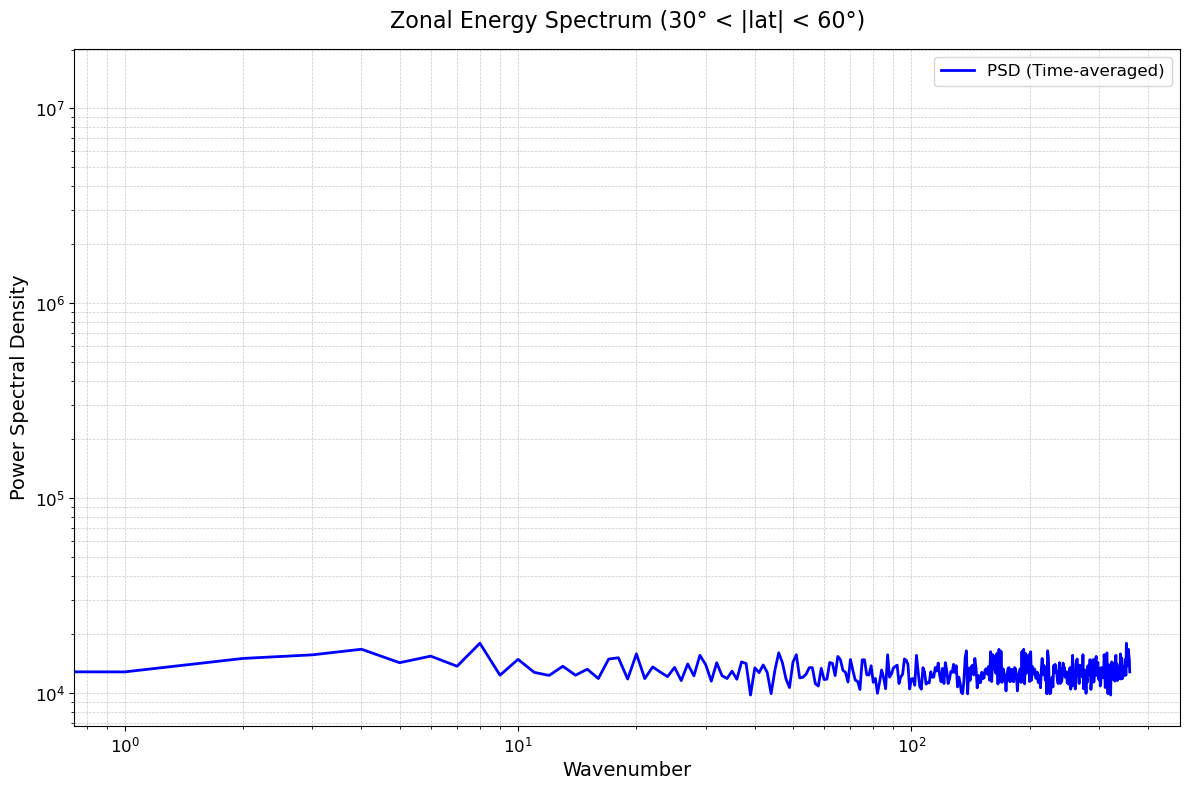

In [ ]:
# Time-averaged PSD
#psd_time_avg = psd.mean(dim="time")
psd_time_avg = psd.sel(time=1)

# Plot the Power Spectral Density (PSD) in WeatherBench2 style
plt.figure(figsize=(12, 8))
plt.loglog(wavenumbers, psd_time_avg, label="PSD (Time-averaged)", linewidth=2, color="blue")

# Customize the plot
plt.xlabel("Wavenumber", fontsize=14)
plt.ylabel("Power Spectral Density", fontsize=14)
plt.title("Zonal Energy Spectrum (30° < |lat| < 60°)", fontsize=16, pad=15)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tick_params(axis="both", which="major", labelsize=12)
plt.legend(fontsize=12, loc="upper right")
plt.tight_layout()

# Show the plot
plt.show()

Try with real data

In [ ]:
dirpath = '/fs/scratch/PYS0343/luisvela/FP_data/ops/data/output/20241213/00'
filename = 'spire-ai.20241213.00z.global.ens_members.0450.nc'
filepath = os.path.join(dirpath, filename)
print('Opening File at:', filepath)

# Load
ds = xr.open_dataset(filepath, engine='h5netcdf').compute()
z500=ds.z.isel(ensemble_member=1,pressure_level=1)

Opening File at: /fs/scratch/PYS0343/luisvela/FP_data/ops/data/output/20241213/00/spire-ai.20241213.00z.global.ens_members.0450.nc


In [ ]:
z500

<xarray.DataArray 'z' (latitude: 721, longitude: 1440)> Size: 4MB
array([[49303.363, 49251.043, 49277.203, ..., 49251.043, 49329.527,
        49355.688],
       [47498.266, 47524.426, 47550.586, ..., 47498.266, 47550.586,
        47445.945],
       [47602.91 , 47681.39 , 47707.55 , ..., 47655.23 , 47655.23 ,
        47655.23 ],
       ...,
       [50768.375, 50768.375, 50768.375, ..., 50768.375, 50768.375,
        50794.535],
       [50585.246, 50611.406, 50611.406, ..., 50585.246, 50637.57 ,
        50611.406],
       [49931.227, 49931.227, 49905.066, ..., 49957.387, 49931.227,
        49905.066]], dtype=float32)
Coordinates:
    lead_time        timedelta64[ns] 8B 18 days 18:00:00
    valid_time       datetime64[ns] 8B 2024-12-31T18:00:00
    ensemble_member  int32 4B 1
  * latitude         (latitude) float32 3kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude        (longitude) float32 6kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    pressure_level   int64 8B 500

In [ ]:
def compute_zonal_energy_spectrum1(da):
    # Restrict latitudes to 30 < |lat| < 60
    lat_mask = (da["latitude"] > 30) | (da["latitude"] < -30)
    lat_mask &= (da["latitude"] < 60) & (da["latitude"] > -60)
    da = da.sel(latitude=lat_mask)

    # Get longitude spacing and circumference (approximation)
    lon_spacing = 360 / da.sizes["longitude"]
    circumference = 2 * np.pi * 6371e3 * np.cos(np.radians(da["latitude"]))  # Earth's radius = 6371 km

    # Compute DFT along longitude (zonal)
    dft = np.fft.fft(da, axis=1) / da.sizes["longitude"]  # Normalize by L
    dft_amplitude = np.abs(dft)  # Amplitude of Fourier coefficients

    # Compute energy spectrum (S_k)
    energy_spectrum = 2 * (dft_amplitude ** 2)  # Factor of 2 for k > 0
    energy_spectrum[..., 0] /= 2  # For k=0, no doubling
    energy_spectrum = energy_spectrum[..., : da.sizes["longitude"] // 2]  # Keep k = 0 to L/2

    # Align circumference_da to match energy_spectrum dimensions
    circumference_da = xr.DataArray(
        circumference, dims=["latitude"], coords={"latitude": da["latitude"]}
    )
    # Expand the circumference to match energy_spectrum dimensions
    circumference_da_expanded = circumference_da.broadcast_like(
        da.isel(longitude=slice(0, energy_spectrum.shape[1]))
    )

    # Scale the energy spectrum with the circumference
    scaled_spectrum = energy_spectrum * circumference_da_expanded
    psd_mean = scaled_spectrum.mean(dim="latitude")  # Average across selected latitudes

    return psd_mean


In [ ]:
psd1 = compute_zonal_energy_spectrum1(z500)

In [ ]:
psd1

<xarray.DataArray 'latitude' (longitude: 720)> Size: 6kB
array([8.20918324e+16, 9.33958276e+12, 5.71904316e+12, 1.42048286e+13,
       3.53178547e+12, 6.82911638e+12, 5.75203377e+12, 1.65087222e+12,
       1.48483186e+12, 3.80601691e+11, 3.54229358e+11, 3.15379511e+11,
       2.28622104e+11, 9.83680571e+10, 7.81052205e+10, 5.99176908e+10,
       3.56867691e+10, 4.04653451e+10, 2.44102868e+10, 3.25265312e+10,
       1.49018821e+10, 2.11610672e+10, 8.31237650e+09, 1.00672680e+10,
       5.38517030e+09, 8.52294220e+09, 3.89396116e+09, 5.20188373e+09,
       5.64312590e+09, 4.20074487e+09, 2.20499846e+09, 1.82651144e+09,
       2.04941070e+09, 1.22932194e+09, 1.27114489e+09, 9.36187180e+08,
       1.78727097e+09, 5.01433618e+08, 8.39443403e+08, 6.06592700e+08,
       8.65862025e+08, 5.09482095e+08, 3.86471334e+08, 5.44047995e+08,
       4.77812460e+08, 4.33664305e+08, 4.04845151e+08, 3.05376842e+08,
       2.20635823e+08, 1.78769459e+08, 3.46925060e+08, 2.26088627e+08,
       1.86357722e+08, 2.04598815e+08, 2.72308186e+08, 2.95599428e+08,
       1.74137387e+08, 1.57675755e+08, 1.48125570e+08, 1.71112283e+08,
       2.00731124e+08, 1.31592102e+08, 1.30839187e+08, 1.48556734e+08,
       1.72648553e+08, 1.67325684e+08, 1.47128372e+08, 1.23363100e+08,
       1.22194427e+08, 1.22351186e+08, 1.23446151e+08, 1.22050324e+08,
       1.01110659e+08, 9.54504672e+07, 1.09812151e+08, 9.13240579e+07,
       1.09039035e+08, 1.26246790e+08, 1.16934382e+08, 8.63713706e+07,
...
       8.31537392e+06, 7.10001869e+06, 7.59144143e+06, 7.08108353e+06,
       8.80854840e+06, 7.09776961e+06, 8.94067460e+06, 7.17353906e+06,
       8.01923729e+06, 6.22882323e+06, 8.46178655e+06, 7.81217136e+06,
       9.01727864e+06, 6.82456928e+06, 8.73871761e+06, 7.14501737e+06,
       8.41454608e+06, 7.22769792e+06, 8.17311252e+06, 8.03214775e+06,
       9.15730854e+06, 7.34085887e+06, 7.97703381e+06, 6.53757157e+06,
       7.47812039e+06, 7.13109238e+06, 7.90315539e+06, 7.60139002e+06,
       8.64232168e+06, 7.08029327e+06, 8.86874684e+06, 7.58489995e+06,
       8.44242235e+06, 6.83311062e+06, 8.77250802e+06, 7.33928103e+06,
       9.16858898e+06, 6.67386803e+06, 8.26446403e+06, 7.43583394e+06,
       8.44399630e+06, 7.55415333e+06, 8.61996455e+06, 6.68378686e+06,
       7.09147013e+06, 6.65776467e+06, 8.67386059e+06, 6.84402997e+06,
       8.11235198e+06, 7.27363376e+06, 7.26402547e+06, 6.71112074e+06,
       7.41757493e+06, 7.18067517e+06, 8.20506463e+06, 7.77300415e+06,
       7.89710184e+06, 6.06755411e+06, 7.17505767e+06, 7.18266577e+06,
       7.54252534e+06, 7.71263876e+06, 7.06286650e+06, 6.61989075e+06,
       7.55185510e+06, 7.22655706e+06, 8.58572330e+06, 6.58527204e+06,
       8.65310493e+06, 6.40404616e+06, 7.81250361e+06, 6.89874332e+06,
       9.53286033e+06, 7.72942556e+06, 8.04319710e+06, 6.87145725e+06,
       7.78279664e+06, 7.22687558e+06, 7.70814602e+06, 6.67480942e+06])
Coordinates:
  * longitude  (longitude) float32 3kB 0.0 0.25 0.5 0.75 ... 179.2 179.5 179.8

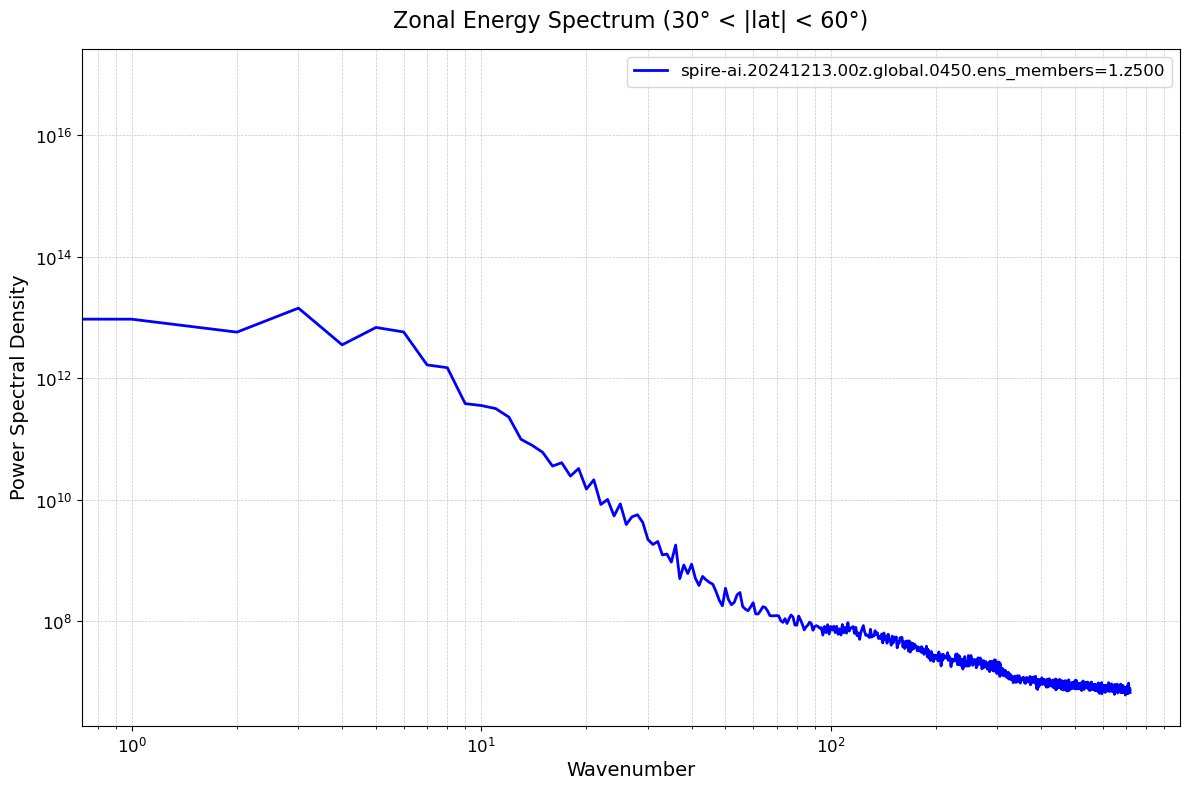

In [ ]:
psd = psd1
#wavenumbers = np.arange(psd.sizes["longitude"] // 2)
wavenumbers = np.arange(psd.sizes["longitude"])
# Plot the Power Spectral Density (PSD) in WeatherBench2 style
plt.figure(figsize=(12, 8))
plt.loglog(wavenumbers, psd, label="spire-ai.20241213.00z.global.0450.ens_members=1.z500", linewidth=2, color="blue")

# Customize the plot
plt.xlabel("Wavenumber", fontsize=14)
plt.ylabel("Power Spectral Density", fontsize=14)
plt.title("Zonal Energy Spectrum (30° < |lat| < 60°)", fontsize=16, pad=15)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tick_params(axis="both", which="major", labelsize=12)
plt.legend(fontsize=12, loc="upper right")
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
wavenumbers

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
psd.sizes["longitude"]


720